## Drosophila Examples for Pairwise Alignment

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.insert(0,'../')
import morpho
import matplotlib.pyplot as plt
import scanpy
import numpy as np
from jupyterthemes import jtplot
jtplot.style(theme="onedork")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
%load_ext autoreload
%autoreload 2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_dir='../data/cellbin_3D'
slice_A = scanpy.read_h5ad(os.path.join(data_dir,'E7-8h_cellbin_v1.h5ad'))
slice_B = scanpy.read_h5ad(os.path.join(data_dir,'E8-9h_cellbin_v1.h5ad'))

In [12]:
slice_A = scanpy.read_h5ad(os.path.join(data_dir,'E8-9h_cellbin_v1.h5ad'))
slice_B = scanpy.read_h5ad(os.path.join(data_dir,'E9-10h_cellbin_v1.h5ad'))

In [17]:
slice_B.obs['Annotation_2_tissue'].cat.categories[0]

'CNS'

In [18]:
sub_num = 10000
slice_A_sub = slice_A[np.random.choice(range(slice_A.shape[0]),sub_num)]
slice_B_sub = slice_B[slice_B.obs['Annotation_2_tissue']=='CNS']

In [19]:
slice_B_sub

View of AnnData object with n_obs × n_vars = 6009 × 8488
    obs: 'area', 'slices', 'Annotation_1_cell_type', 'Annotation_2_tissue', 'Annotation_3_germ_layer', 'actual_time'
    uns: '__type'
    obsm: '3d_align_spatial', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'spatial', 'tdr_spatial', 'tdr_spatial_zero'
    layers: 'counts_X', 'log1p_counts_X'

In [9]:
sub_num = 10000
slice_A_sub = slice_A[np.random.choice(range(slice_A.shape[0]),sub_num)]
slice_B_sub = slice_B[np.random.choice(range(slice_B.shape[0]),sub_num)]

In [10]:
slice_A_sub

View of AnnData object with n_obs × n_vars = 10000 × 6868
    obs: 'area', 'slices', 'Annotation_1_cell_type', 'Annotation_2_tissue', 'Annotation_3_germ_layer', 'actual_time'
    uns: '__type'
    obsm: 'X_pca', 'X_umap', 'align_spatial', 'bbox', 'contour', 'spatial', 'tdr_spatial'
    layers: 'counts_X'

In [11]:
slice_A_sub.obs['Annotation_2_tissue'].cat.categories

Index(['CNS', 'amnioserosa', 'epidermis', 'mesoderm', 'midgut', 'muscle',
       'unknown', 'yolk'],
      dtype='object')

In [21]:
align_model_A, align_model_B, P, _ = morpho.morpho_align_pairwise(
            model_ref=slice_A_sub,
            model=slice_B_sub,
            spatial_key="tdr_spatial",
            key_added="align_spatial",
            select_high_exp_genes=False,
            normalize_c=True,
            normalize_g=False,
            dissimilarity='kl',
            mode="SN",
            device="1",
            max_iter=100,
            dtype='float64',
            beta2=0.5,
            verbose=True,
            iter_key_added='iter_spatial',
            keep_size=False,
            layer='counts_X',
        )

|-----> Start alignment based on morph, mode: SN.
|-----> Filtered all samples for common genes. There are 7894 common genes.
|-----> Coordinates normalization params:
|-----------> Scale: 139.39642848230022.
|-----> [Start morpho alignment] in progress: 100.0000%
|-----> [Start morpho alignment] finished [5.2115s]
tensor(0.9900, device='cuda:0', dtype=torch.float64)


In [32]:
align_models, pis = morpho.models_align(
    models=[slice_A_sub,slice_B_sub],
    # layer='counts_X',
    spatial_key="tdr_spatial",
    key_added="align_spatial",
    device="1",
)

|-----> [Models alignment] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 7894 common genes.


RuntimeError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 23.70 GiB total capacity; 10.97 GiB already allocated; 192.56 MiB free; 11.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

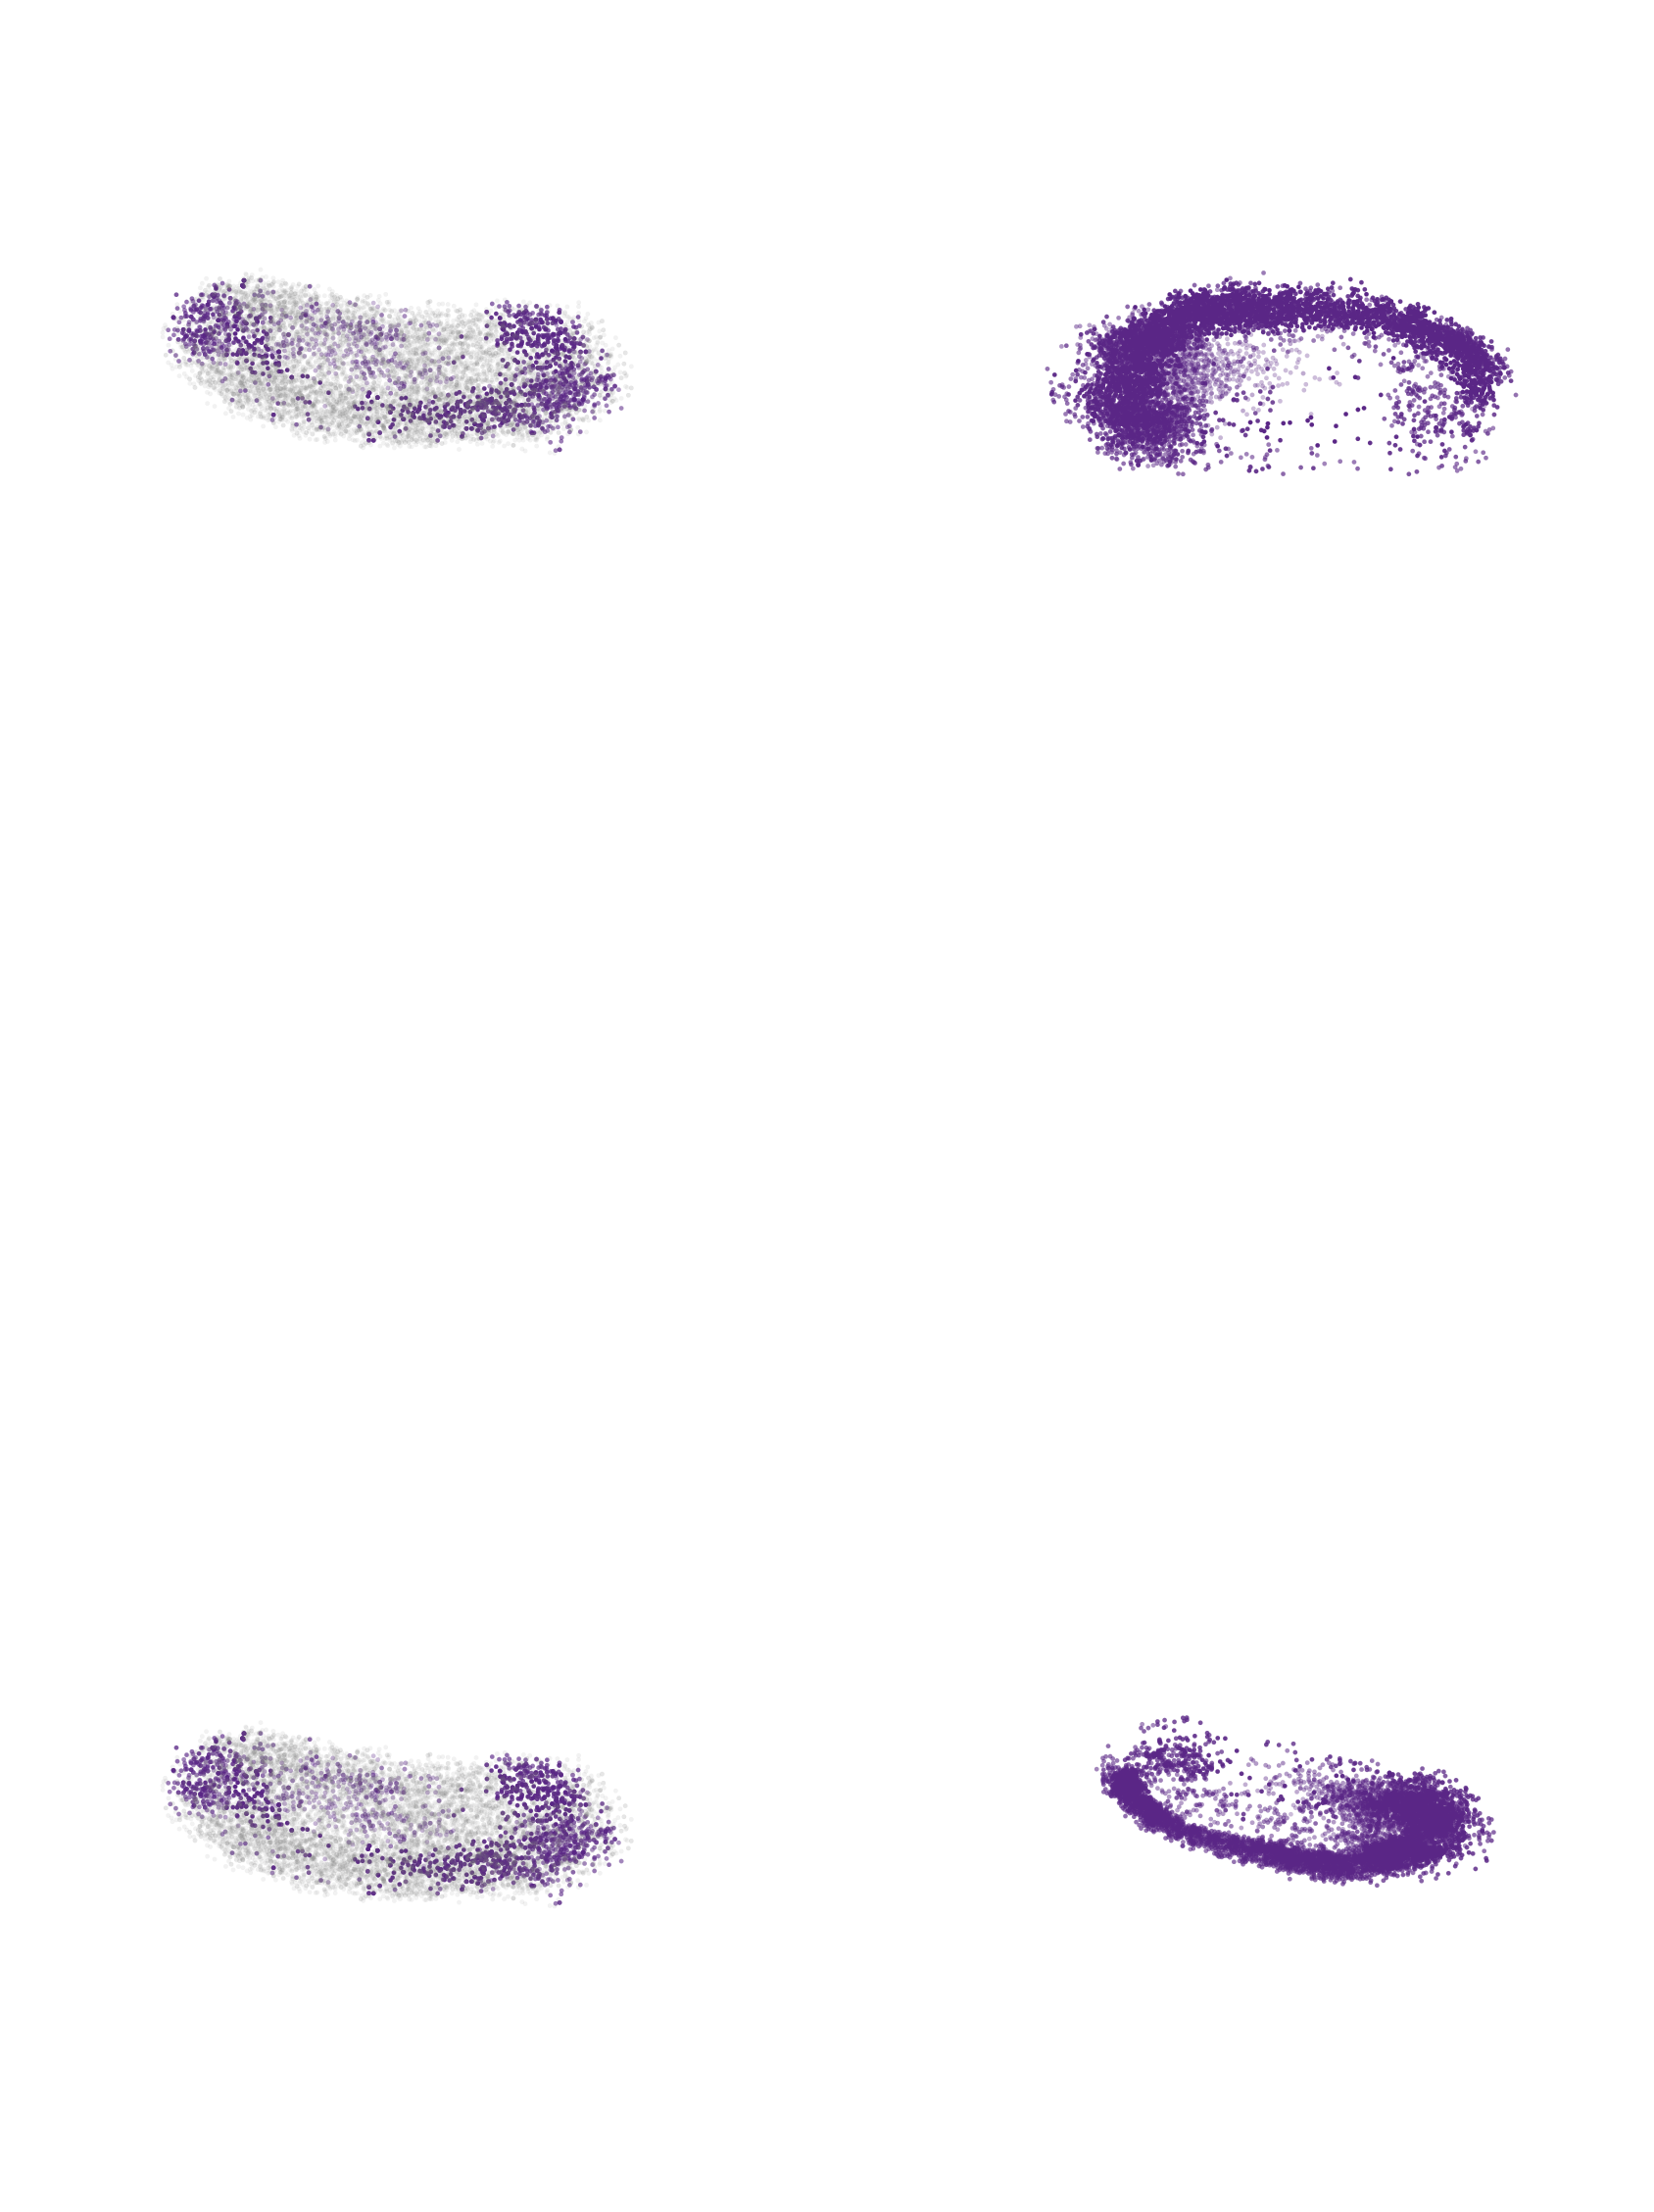

In [26]:
# %matplotlib widget
spatial_key="tdr_spatial"
key_added="align_spatial"
%matplotlib inline
colormap = [
    "#5A2686",
    "#DC143C",
    "#FFDD00",
    "#FFA500",
    "#ADD8E6",
    "#1AAB27",
    "#7F90F0",
    "#CD5C5C",
    "#8B0000",
    "#CD5C5C",
    "#7F90F0",
]
elev = 90
azim = -90
s = 20
xmin, xmax = -250,250
ymin,ymax = -250,250
zmin,zmax = -250,250
cell_type_plot='CNS'
cell_type_layer = 'Annotation_2_tissue'
fig = plt.figure(figsize=(30,50),facecolor='white')
ax = fig.add_subplot(2,2,1,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(2,2,2,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')

ax = fig.add_subplot(2,2,3,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(2,2,4,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')


In [33]:
morpho.three_d_pairwise_animate(
    model_ref=align_model_A,
    model=align_model_B,
    spatial_key="tdr_spatial",
    fps=5,
)

|-----> [Start morpho alignment] in progress: 100.0000%
|-----> [Start morpho alignment] finished [0.0868s]


NameError: name 'align_models' is not defined

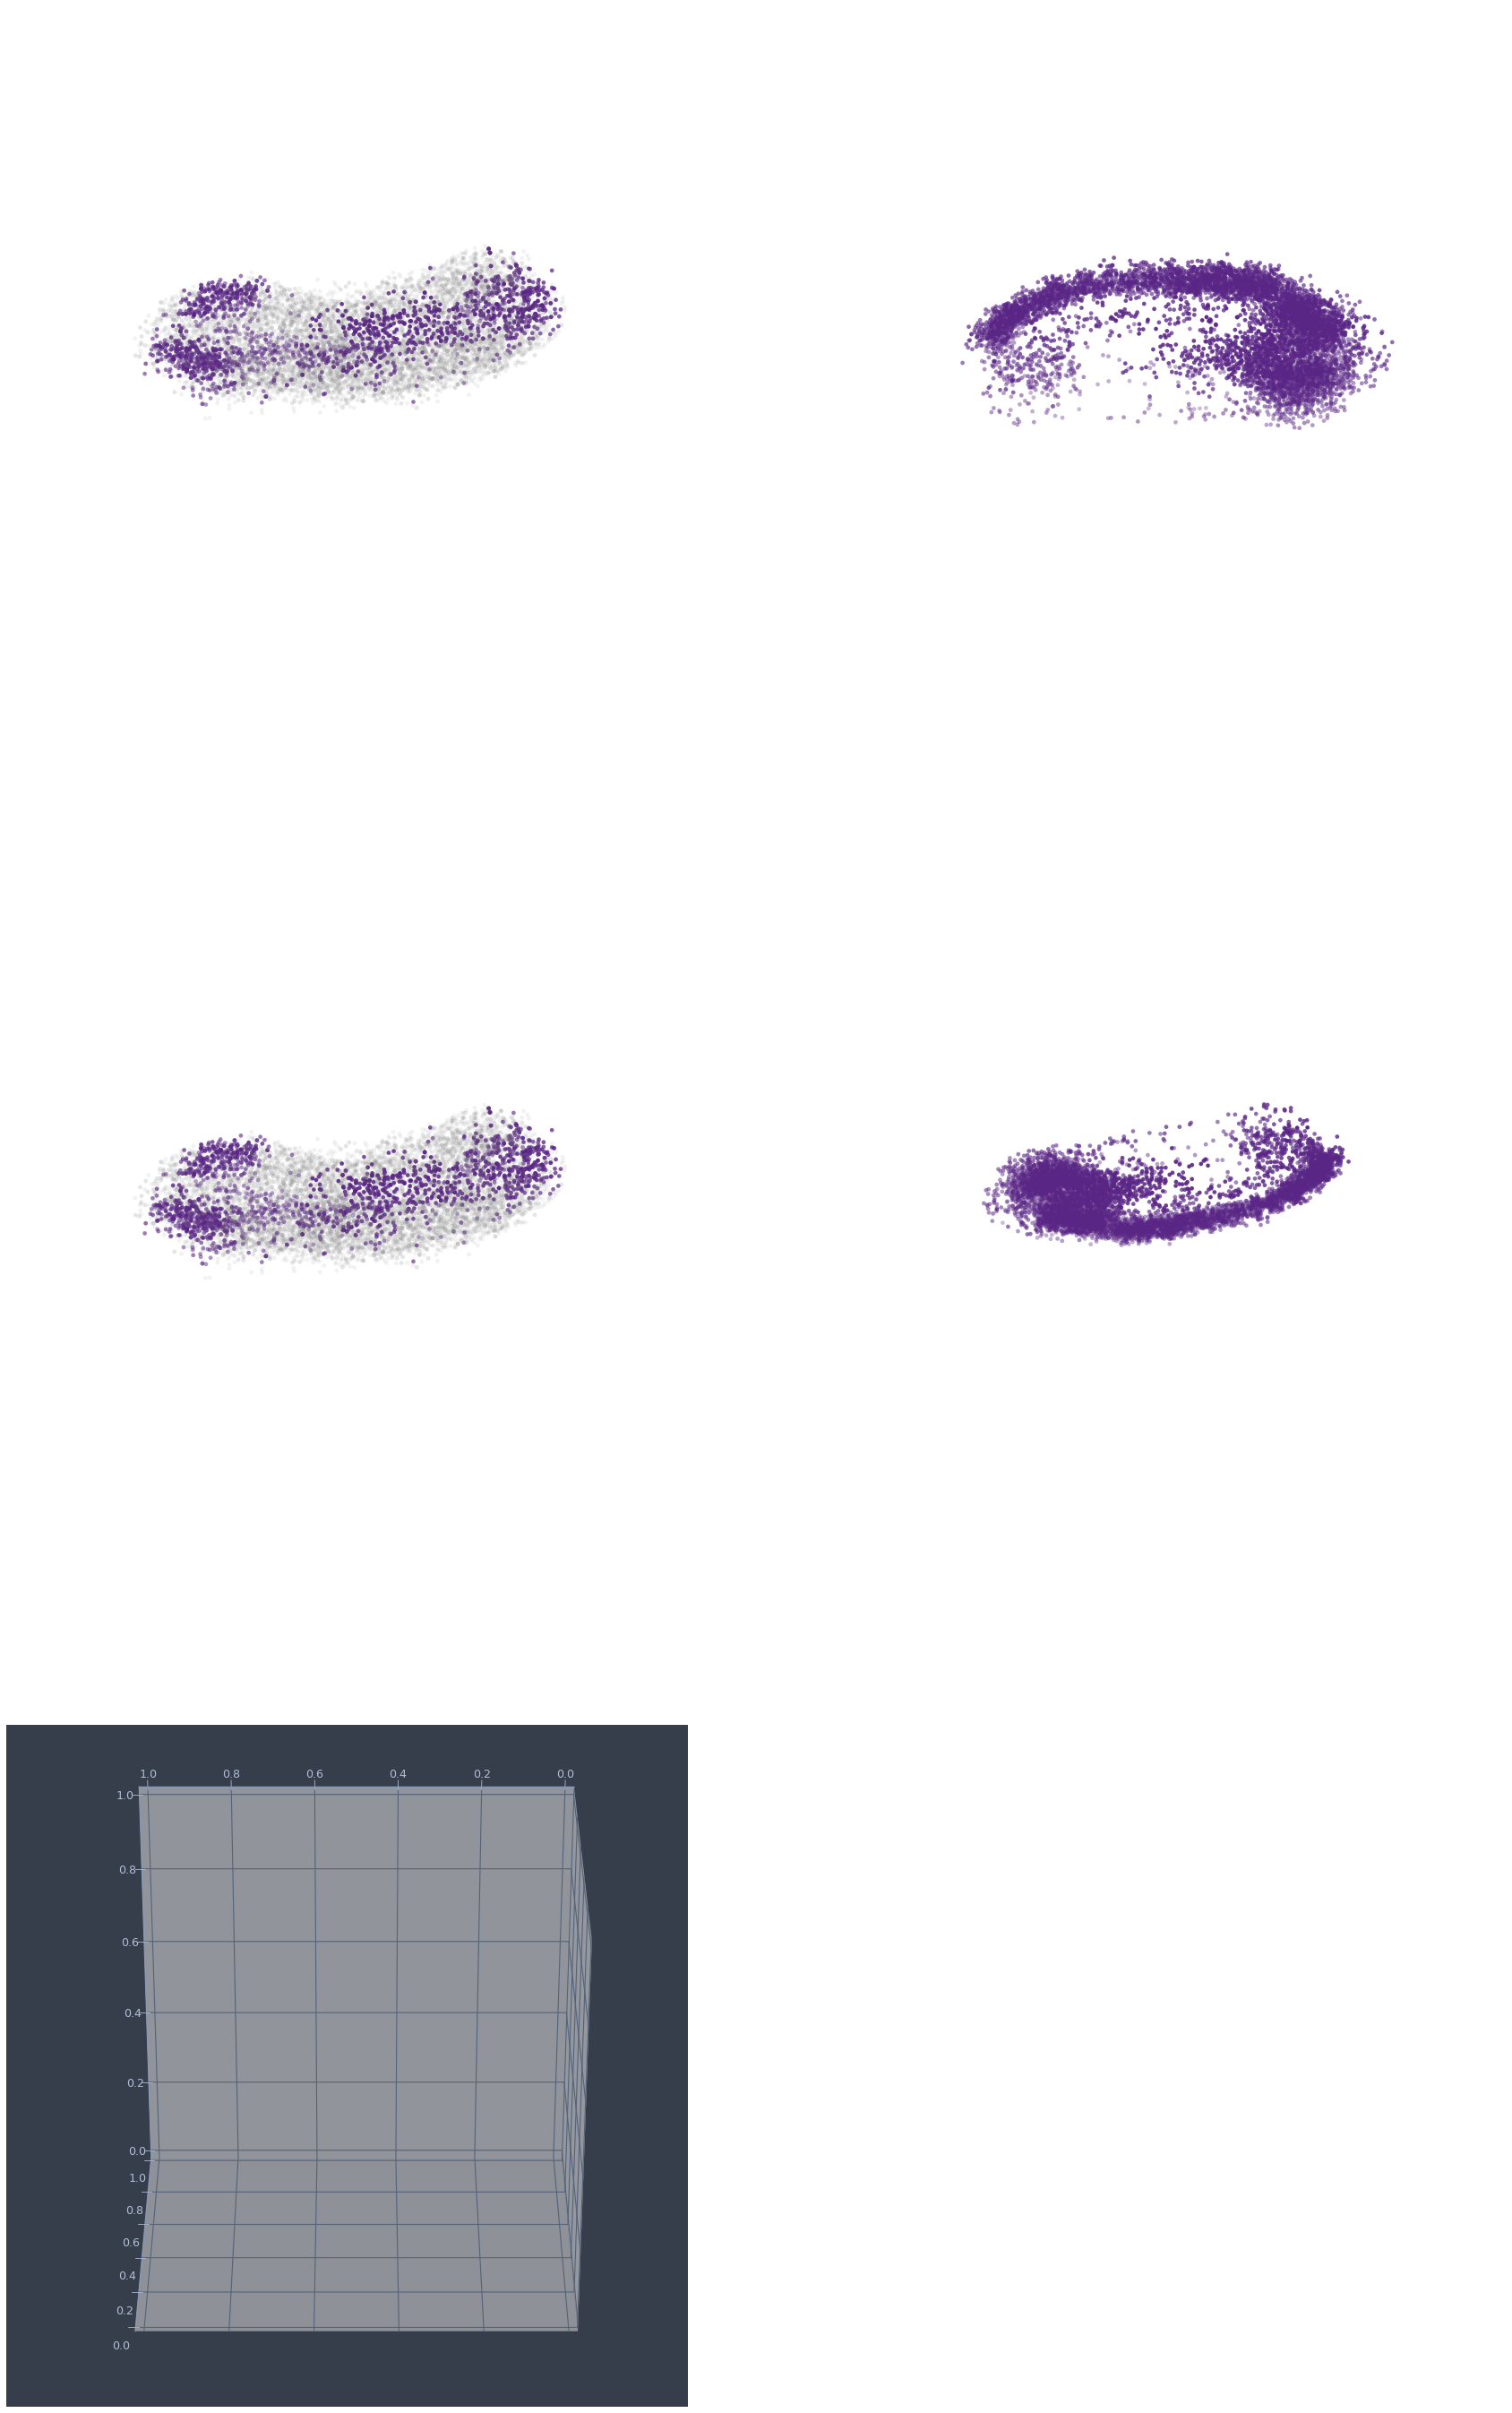

In [24]:
# %matplotlib widget
spatial_key="tdr_spatial"
key_added="align_spatial"
%matplotlib inline
colormap = [
    "#5A2686",
    "#DC143C",
    "#FFDD00",
    "#FFA500",
    "#ADD8E6",
    "#1AAB27",
    "#7F90F0",
    "#CD5C5C",
    "#8B0000",
    "#CD5C5C",
    "#7F90F0",
]
elev = -60
azim = -90
s = 20
xmin, xmax = -250,250
ymin,ymax = -250,250
zmin,zmax = -250,250
cell_type_plot='CNS'
cell_type_layer = 'Annotation_2_tissue'
fig = plt.figure(figsize=(30,50),facecolor='white')
ax = fig.add_subplot(3,2,1,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(3,2,2,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm[spatial_key][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')

ax = fig.add_subplot(3,2,3,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_A[slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(3,2,4,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_model_B[slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(3,2,5,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_models[0][slice_A_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)    
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')
ax = fig.add_subplot(3,2,6,projection='3d')
ax.view_init(elev=elev, azim=azim)
for index,cell_type in enumerate(slice_A_sub.obs[cell_type_layer].cat.categories):
    if cell_type == cell_type_plot:
        ax.scatter(align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,c=colormap[index%len(colormap)])
    else:
        ax.scatter(align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,0],align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,1],align_models[1][slice_B_sub.obs[cell_type_layer]==cell_type].obsm['align_spatial'][:,2],marker='o',s=s,color=[0.5,0.5,0.5],alpha=0.1)
    
ax.set_zlim([zmin,zmax])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.axis('off')
ax.set_facecolor('white')